In [1]:
from pylab import *
from numpy.linalg import norm
from numpy import random
from scipy import interpolate,integrate
from ipywidgets import IntProgress
from IPython.display import display,clear_output
from scipy.integrate import simps
from matplotlib import rc

import os.path as path
import sys
import pandas as pd

rcParams['figure.figsize'] = [8, 8]
rcParams['axes.labelsize'] = 20
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage[russian]{babel}',
                         r'\usepackage{amsmath}',
                        r'\usepackage{amssymb}',
                        r'\usepackage{mathrsfs}'])
rc('font', family='serif')

In [2]:
class Spectrum:
    def __init__(self,
                 KT=array([0.02,2000]), 
                 U10=5, x=20170):
        # Задание основных констант
        self.g = 9.81  #ускорение свободного падения.
        self.KT = KT   #массив с границами моделируемого спектра.
        self.U10 = U10 #скорость ветра на высоте 10 м над уровнем моря.
        self.gamma = self.Gamma(x) #коэффициент gamma (см. спектр JONSWAP)
        self.alpha = self.Alpha(x) #коэффициент alpha (см. спектр JONSWAP)
        self.omega = self.Omega(x) *self.g/self.U10 #координата пика спектра
        self.k_m = self.k_max( self.omega ) #координата пика спектра
        # См. функции spectrum_{1-4}(k).
        # limit_{1-4} -- это соответствующие границы
        self.limit_1= 1.2
        self.limit_2=(
                 +0.371347584096022408 
                 + 0.290241610467870486*self.U10
                 + 0.290178032985796564/self.U10
                )
        self.limit_3= 270.0
        self.limit_4= 1020.0
        self.limit_k=np.zeros(4)
        self.limit_k[0]=self.find_decision(self.limit_1*self.omega)
        self.limit_k[1]=self.find_decision(self.limit_2*self.omega)
        self.limit_k[2]=self.limit_3
        self.limit_k[3]=self.limit_4
        #k0-- просто густая сетка, нужна для интегрирования и интерполирования
        self.k0= logspace(log10(KT[0]), log10(KT[-1]),10**5)  
        self._full_spectrum=self.interpolate()
        
    def get_full_spectrum(self):
        return self._full_spectrum
    
    def find_decision(self,omega):
        P = 9.8*1000.0/0.074;
        Q = -1000.0*omega**2/0.074;
        x1= -Q/2.0 + sqrt( (Q/2)**2 + (P/3)**3 )
        x2= -Q/2.0 - sqrt( (Q/2)**2 + (P/3)**3 )
        k=x1**(1/3)-(-x2)**(1/3)
        return k

    def det(self,k): 
    #        Функция возвращает Якобиан при переходе от частоты к 
    #    волновым числам по полному дисперсионному уравнению

        det=(9.8+3*k**2*0.074/1000)/(2*sqrt(9.8*k+k**3*0.074/1000) )
        return det

    def k_max(self,omega_max):
        # k_max -- координата пика спектра
        k_max=omega_max**2/self.g
        return k_max

    def omega_k(self,k): 
        #    Пересчет волнового числа в частоту по полному дисперсионному
        # уравнению   
        omega_k=(self.g*k+0.074*k**3/1000)**(1/2) 
        return omega_k  

    def JONSWAP(self,k):
        if k<=self.k_m:
            sigma=0.07
        else:
            sigma=0.09
        Sw=(
            self.alpha/2*k**(-3)*exp(-1.25*(self.k_m/k)**2 )*
            self.gamma**(exp(- ( sqrt(k/self.k_m)-1)**2 / (2*sigma**2) ))
           )
        return Sw

    # Безразмерный коэффициент Gamma
    def Gamma(self,x):
        if x>=20170:
            return 1
        gamma=(
               +5.253660929
               +0.000107622*x
               -0.03778776*sqrt(x)
               -162.9834653/sqrt(x)
               +253251.456472*x**(-3/2)
              )
        return gamma

    # Безразмерный коэффициент Alpha
    def Alpha(self,x):
        if x>=20170:
            return 0.0081
        alpha=array([],dtype='float64')
        alpha=[( 
               +0.0311937
               -0.00232774*log(x)
               -8367.8678786/x**2
               +4.5114599e+300*exp(-x)*1e+300*1e+17
    #            +4.5114599e+17*exp(-x)
              )]
        return alpha[0]

    #Вычисление безразмерной частоты Omega по безразмерному разгону x
    def Omega(self,x): 
        if x>=20170:
            return 0.835
        omega_tilde=(0.61826357843576103 
                     + 3.52883010586243843e-06*x
                     - 0.00197508032233982112*sqrt(x)
                     + 62.5540113059129759/sqrt(x)
                     - 290.214120684236224/x
        )
        return omega_tilde

    def spectrum1(self,k):
        # Граница моделируюмого спектра #1
        # 1.2*omega_max < omega < a_m omega_m
        omega0=self.omega_k(self.limit_k[0])
        beta0= self.JONSWAP(self.limit_k[0])*omega0**4\
              /self.det(self.limit_k[0])
        omega0=self.omega_k(k)
        return beta0/omega0**4*self.det(k)

    def spectrum2(self,k):
        # Граница моделируюмого спектра #2
        # a_m(U_10) omega_m < omega < omega_gk simeq 60 рад/с
        omega0=self.omega_k(self.limit_k[1])
        beta0= self.spectrum1(self.limit_k[1])*omega0**5\
              /self.det(self.limit_k[1])
        omega0=self.omega_k(k)
        return beta0/omega0**5*self.det(k)

    def spectrum3(self,k):
        # Граница моделируюмого спектра #3
        #  omega_gk < omega < omega_h simeq 290 рад/с
        omega0=self.omega_k(self.limit_k[2])
        beta0= self.spectrum2(self.limit_k[2])*omega0**2.7\
              /self.det(self.limit_k[2])
        omega0=self.omega_k(k)
        return beta0/omega0**2.7*self.det(k)

    def spectrum4(self,k):
        # Граница моделируюмого спектра #4
        #  omega_h < omega 
        omega0=self.omega_k(self.limit_k[3])
        beta0= self.spectrum3(self.limit_k[3])*omega0**5\
              /self.det(self.limit_k[3])
        omega0=self.omega_k(k)
        return beta0*self.det(k)/omega0**5
    
    def full_spectrum(self,k,x=20170):
        #    Спектр JONSWAP. 
        #    По совместительству, граница моделируюмого спектра #0
        # 0< omega < 1.2*omega_max 
        try:
            full_spectrum=zeros(len(k))
        except:
            full_spectrum=[0]
            k=[k]
            
        # Цикл ниже сшивает спектр на границах.
        for i in range(len(k)):
            if k[i] <= self.limit_k[0]:
                full_spectrum[i] =  self.JONSWAP(k[i])
            elif k[i] <= self.limit_k[1]:
                full_spectrum[i] = self.spectrum1(k[i])
            elif k[i] <= self.limit_k[2]:
                full_spectrum[i] = self.spectrum2(k[i])
            elif k[i] <= self.limit_k[3]:
                full_spectrum[i] = self.spectrum3(k[i])
            else:
                full_spectrum[i] = self.spectrum4(k[i])  
        return full_spectrum
    
    def interpolate(self):
        # Интерполируем наш спектр. 
        # Позволяет не думать над различными размерами массивов при счете
        full_spectrum=interpolate.interp1d(self.k0, self.full_spectrum(self.k0))
        return full_spectrum

In [3]:
class correlation:
    def angles(self,k,rho):
        integral=zeros(len(rho))
        y=lambda k,rho: k**2*self.full_spectrum(k)*cos(k*rho)
        for i in range(len(rho)):
            integral[i]=trapz(y(k,rho[i]),x=k)
        integral=interpolate.interp1d(rho,integral)
        return integral

    def angles_sum(self,k,rho):
        f=0
        A=self.amplitude(k)
        f=zeros(len(rho))
        for j in range(len(rho)):
                f[j]=sum( k**2*A**2/2*cos(k*rho[j]) )

        return f

    def height(self,k,rho):

        S=self.full_spectrum(k)
        integral=zeros(len(rho))
        for i in range(len(rho)):
            integral[i]=trapz(S*cos(k*rho[i]),k)
        integral=interpolate.interp1d(rho,integral)
        return integral

    def height_sum(self,k,rho):
        f=0
        A=self.amplitude(k)
        f=zeros(len(rho))
        for j in range(len(rho)):
                f[j]=sum( A**2/2*cos(k*rho[j]) )
        return f

In [4]:
class Model(Spectrum):
    def __init__(self,N, M, spectrum, space='log'):
        
        self.N = N
        self.M = M
        
        if space=='log':
            self.k_log = logspace(log10(KT[0]), log10(KT[-1]),N)
            self.k=self.k_log
        elif space=='lin':
            self.k_lin = linspace(KT[0], KT[-1], N)
            self.k=self.k_lin
        elif space=='white':
            ki,b0,err=self.interspace(self.k0,N)
            k=nodes(ki,b0)
            

        self.phi=linspace(-pi,pi,M)
        self.full_spectrum = spectrum.interpolate() #интерполируем смоделированный спектр
        self.A = self.amplitude(self.k) #массив с амплитудами i-ой гармоники
        self.F = self.angle(self.k,self.phi) #угловое распределение
        self.psi = array([
        [ random.uniform(0,2*pi) for j in range(100)] 
                                 for i in range(self.N)  ]) #случайные фазы
        
        
        
        
    def B(self,k):
        def b(k):
            b=(
                -0.28+0.65*exp(-0.75*log(k/spectrum.k_m))
                +0.01*exp(-0.2+0.7*log10(k/spectrum.k_m))  
              )          
            return b
        B=10**b(k)
        return B

    def Phi(self,k,phi):
        # Функция углового распределения
        # Костыль в виде try-except мне был нужен, 
        # чтобы можно было считать числа, а не массивы. Зачем? Уже не помню.
        normalization= lambda B: B/arctan(sinh(2*pi*B))
        try:
            Phi=zeros((len(k),len(phi)))
            for i in range(len(k)):
                B0=self.B(k[i])
                A0=normalization(B0)
                Phi[i]=A0/cosh(2*B0*phi)
        except:
            B0=self.B(k)
            A0=normalization(B0)
            Phi=A0/cosh(2*B0*phi)
            pass
        return Phi

    def angle(self,k,phi):
        angle=sqrt( 2*pi/100 * self.Phi(k,phi) )
        return angle

    def amplitude(self,k):
        # k-- выбранный диапазон волновых чисел
        # N-- количество моделируемых гармоник
        N = len(k)
        S = self.full_spectrum(k)
        dk = zeros(N)
        dS = zeros(N)
        if len(k) == 1:
            dk[0] = k[0]
            dS[0] = S[0]
        for i in range(1,N):
            dk[i] = (k[i] - k[i-1])
            dS[i] = S[i]
        amplitude = sqrt(2 * dk * dS)
        return amplitude

    def model(self, k,phi,t=[0]):
        def water(r,phi,t=[0]):
            self.surface=0
            N=self.N
            A=self.A
            F=self.F
            psi=self.psi
#             print(A)
#             print(F)
            f = IntProgress(min=0,max=N*len(phi))
            display(f,'Строю поверхность t='+str(t[0]))
            for n in range(N):
                for m in range(len(phi)): 
                   
                    self.surface+=A[n]*cos(
                        k[n]*(r[0]*cos(phi[m])+r[1]*sin(phi[m]))+
                        psi[n][m]+
                        spectrum.omega_k(k[n])*t[0]
                    )*F[n][m]
                    f.value+=1
#                     print(self.surface)
            clear_output()
            return self.surface
        return water
    
    def main(self, k, phi, t):
        self.model_t=[self.model(k,phi,t[i]) for i in range(len(t))]
        return self.model_t

In [5]:
class whitening:
#     def __init__(main):
#         self.main=main
    def interspace(self, k, N,cache=True):
        # Функция разбивает заданный k-интервал на N участков, в каждои из которых
        # интеграл по спектру принимает одно и тоже значение. 
        # Для метода <<отбеливания спектра>>.
        y = lambda k: self.full_spectrum(k)*k**self.power
        sigma = trapz(y(k),k)
        b0 = sigma/(N)
        k_new = k[0]
        a = k[-1]
        k = zeros(N+1)
        k[0] = k_new
        err = zeros(N)

        file ='interspace_'+identification+'.tsv'
        if (path.isfile(file) and cache)== True:
            data = pd.read_csv(file,sep='\t')
            nodes = array(data['k'])
            return k,b0,err

        epsabs = 1.49e-12
        epsrel = 1.49e-12
        f = IntProgress(min=0,max=N-1)
        display(f,'Разбиваю на интервалы')
        for i in range(N-1):
            integral = 0
            n = 1
            m = 2
            while integral < b0:
                k_new*= 1 + 10**(-m)
                if k_new > a:
                    k_new = a
                    break
                integral,error = integrate.quad(y, k[i], k_new,
                limit = 50,epsabs = epsabs, epsrel=epsrel)
                if integral> b0 and abs(integral-b0) > epsabs:
                    k_new*= 1 - 10**(-m)
                    m+= 1
                    integral, error = integrate.quad(y, k[i], k_new,
                    limit=50, epsabs=epsabs, epsrel=epsrel)
                n+= 1
            f.value+= 1
            k[i+1] = k_new
        k = k[0:N+1]
        k[-1] = a
        # Возвращает k размерности N+1, т.о. имеем как раз N интервалов.
        # b0 -- значение интеграла по каждому интервалу
        # err -- ошибка вычисения интегралов
        clear_output()

        file = 'interspace_'+identification+'.tsv'
        df = pd.DataFrame({'k': k})
        df.to_csv(file,sep = '\t')
        return k,b0,err

    def nodes(self,ki,b0, cache=True):
        file='node_'+identification+'.tsv'
        if (path.isfile(file) and cache)==True:
            data=pd.read_csv(file,sep='\t')
            nodes=array(data['k'])
            return nodes

        else:
            # Функции interspace и nodes используются последовательно. 
            # Первая возвращает интервалы,
            # а вторая вычисляет в возвращенных интервалах координаты узлов
            f=IntProgress(min=0,max=len(ki))
            display(f,'Считаю узлы в интервалах')
            y=lambda k: k**(self.power+2)*self.full_spectrum(k)
            nodes=zeros(len(ki))
            epsabs=1.49e-12
            epsrel=1.49e-12
            A=sqrt(2*b0)
            for i in range(1,len(ki)):
                integral,error=integrate.quad(y,ki[i-1],ki[i],
                limit=50,epsabs=epsabs, epsrel=epsrel)
                B=(sqrt(integral/A**2))
                nodes[i-1]=B
                f.value+=1

            clear_output()
            file='node_'+identification+'.tsv'
            df=pd.DataFrame({'k': nodes[:-1]})
            df.to_csv(file,sep='\t')
            return nodes[:-1]

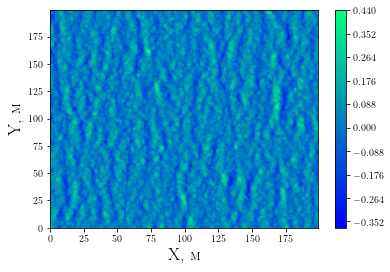

In [6]:
if __name__ == "__main__":
    identification='slopes'
    # identification='height'
    if identification=='slopes':
        power=2
    elif identification=='height':
        power=0
        
    KT=array([0.02,2000])
    rho=linspace(0,100,100)
    x=linspace(0,400,200)
    y=linspace(0,400,200) 
    t=linspace(0,120,1)

    N=256
    M=50
    U10=10
    spectrum=Spectrum()
    model=Model(N,M,spectrum)
    model_t = model.main(model.k,model.phi,t)

    x, y = np.meshgrid(x, y)
    
    
    for i in range(len(t)):
        figure()
        z=model_t[i]([x,y],model.phi,t=[t[i]])
        contourf(z,100,cmap=cm.winter)
        colorbar()
        ylabel(r'Y, \text{м}',fontsize=16)
        xlabel(r'X, \text{м}',fontsize=16)
    #   savefig(path.abspath('..'+'\\water\\anim\\'+'water'+str(i)+'.png'),
    #             pdi=10**6,bbox_inches='tight')
        show()

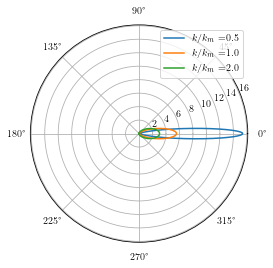

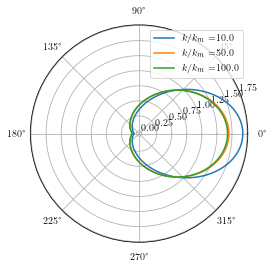

In [12]:
k_m=spectrum.k_m
x=linspace(-pi,pi,10000)
temp=[k_m/2,k_m,2*k_m]
for t in temp:
    y=model.Phi(t,x)
    polar(x,y/k_m,label=r'$k/k_m=$' + str(round(t/k_m,3)))
legend()
# savefig(path.abspath('..'+'\\fig\\full_angles1.pdf'),
#        bbox_inches='tight')
show()
temp=[10*k_m,50*k_m,100*k_m]
for t in temp:
    y=model.Phi(t,x)
    polar(x,y/k_m,label=r'$k/k_m=$' + str(round(t/k_m,3)))
legend()
# savefig(path.abspath('..'+'\\fig\\full_angles2.pdf'),
#        bbox_inches='tight')
show()

In [13]:
trapz(model.Phi(k_m/2,x),x)

0.9999999999999998

In [7]:
# identity=1
# rho=linspace(0,400,400)
# y=zeros(len(rho))
# k=logspace(log10(m.KT[0]),log10(m.KT[-1]),10**5)
# y1=m.angles(k,rho)
# k=logspace(log10(m.KT[0]),log10(m.KT[-1]),256)
# y=m.angles_sum(k,rho)
# y1=y1(rho)
# real=y1/max(y1)
# modeling=y/max(y)
# plot(rho,real,label='Реальное поле',color='crimson')
# plot(rho,modeling,label='Модельное поле',color='darkblue')
# legend(fontsize=16)
# xlabel(r'${\rho},\text{м}$',fontsize=16)
# ylabel(r'$K_{\theta}, a.u.$',fontsize=16)
# grid(which='major', linestyle='-')
# grid(which='minor', linestyle=':')
# minorticks_on()

# # savefig(path.abspath('..'+'\\water\\TeX\\fig\\correlation_height_'
# #                      +identification+str(identity)+'.pdf'),
# #        bbox_inches='tight')
# show()

In [8]:
# from numpy.linalg import norm
# norm(abs(real-modeling))

In [9]:
# ki,b0,err=m.interspace(m.k0,int(N),cache=False)
# ki=m.nodes(ki,b0,cache=False)

In [10]:
# rho=linspace(0,400,400)
# y=zeros(len(rho))
# k=logspace(log10(m.KT[0]),log10(m.KT[-1]),10**5)
# y1=m.angles(k,rho)
# y=m.angles_sum(ki,rho)
# y1=y1(rho)
# real=y1/max(y1)
# modeling=y/max(y)
# plot(rho,real,label='Реальное поле',color='crimson')
# plot(rho,modeling,label='Модельное поле',color='darkblue')
# legend(fontsize=16)
# xlabel(r'${\rho},\text{м}$',fontsize=16)
# ylabel(r'$K_{\theta}, a.u.$',fontsize=16)
# grid(which='major', linestyle='-')
# grid(which='minor', linestyle=':')
# minorticks_on()

# # savefig(path.abspath('..'+'\\water\\TeX\\fig\\correlation_height_'
# #                      +identification+str(identity)+'.pdf'),
# #        bbox_inches='tight')
# show()

In [11]:
# norm(abs(real-modeling))